In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer, LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from xgboost import plot_importance


from mlxtend.preprocessing import DenseTransformer
from mlxtend.feature_selection import ColumnSelector
from ipypb import track, irange, ipb
from scipy import stats
from itertools import product

sns.set(color_codes=True)

In [2]:
logger = logging.getLogger('ai')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s  %(filename)s : %(levelname)s  %(message)s')

# Features Engineering

## outliers

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv('../input/sales_train.csv', parse_dates = ['date'], date_parser=dateparse)

In [4]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
sales_detail_df = sales_df.groupby([sales_df.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'}).reset_index()
sales_detail_df.head()

,date,item_id,shop_id,item_cnt_day,item_price
0,2013-01,19,25,1.0,28.0
1,2013-01,27,1,1.0,1890.0
2,2013-01,27,2,1.0,2499.0
3,2013-01,27,10,1.0,1890.0
4,2013-01,27,19,1.0,2499.0


In [4]:
item_df = pd.read_csv('../input/items.csv')
shop_df = pd.read_csv('../input/shops.csv')
category_df = pd.read_csv('../input/item_categories.csv')

In [5]:
'''
test_df = pd.read_csv('../input/test.csv').set_index('ID')
'''

"\ntest_df = pd.read_csv('../input/test.csv').set_index('ID')\n"

### Clear the data out of range

In [6]:
logger.info("item_price more than 100000 is %d" % sales_df[sales_df.item_price > 100000].shape[0])
logger.info("item_cnt_day more than 1000 is %d" % sales_df[sales_df.item_cnt_day > 1000].shape[0])

2019-02-14 21:21:16,449  <ipython-input-6-ea685e07fb41> : INFO  item_price more than 100000 is 1
2019-02-14 21:21:16,454  <ipython-input-6-ea685e07fb41> : INFO  item_cnt_day more than 1000 is 1


In [7]:
sales_df = sales_df[sales_df.item_price<100000]
sales_df = sales_df[sales_df.item_cnt_day<1000]

### Correct the negative item price

In [8]:
sales_df[sales_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
sales_df.at[484683, 'item_price'] = sales_df[(sales_df.item_id == 2973) & (sales_df.item_price > 0)].item_price.mean()

### Adjust duplicates by shop name

According to the reference, some shops are duplicates. This feature found is based on the language background.

In [10]:
shop_df[shop_df.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [11]:
shop_df[shop_df.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


The shop_id 0 and 57 are the same shop. And other pairs are 1 and 58, 10 and 11.

In [12]:
# Якутск Орджоникидзе, 56
sales_df.at[sales_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_df.at[sales_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_df.at[sales_df.shop_id == 10, 'shop_id'] = 11

## Merge Data into one entity

In [13]:
# refer to feature-engineering-xgboot
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_df[sales_df.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [14]:
sales_detail_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
sales_price_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index(name='item_avg_price')

sales_detail_df = pd.merge(sales_detail_df, sales_price_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')

matrix = pd.merge(matrix, item_df, on=['item_id'], how='left')
matrix = pd.merge(matrix, shop_df, on=['shop_id'], how='left')
matrix = pd.merge(matrix, category_df, on=['item_category_id'], how='left')

sales_detail_df = pd.merge(matrix, sales_detail_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
sales_detail_df['item_cnt_month'] = sales_detail_df['item_cnt_month'].fillna(0)

## Basic Features

+ **Feature 'city'**: Each shop_name starts with the city name.

In [15]:
sales_detail_df.loc[sales_detail_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
sales_detail_df['shop_name'] = sales_detail_df['shop_name'].astype(str)
sales_detail_df['city'] = sales_detail_df['shop_name'].str.split(' ').map(lambda x: x[0])
sales_detail_df.loc[sales_detail_df.city == '!Якутск', 'city'] = 'Якутск'

encoder = LabelEncoder()
encoder.fit(sales_detail_df['city'])
sales_detail_df['city_code'] = encoder.transform(sales_detail_df['city'])

+ **Feature 'type'**: Each category contains type and subtype in its name.
+ **Feature 'subtype'**: Each category contains type and subtype in its name.

In [16]:
sales_detail_df['item_category_name'] = sales_detail_df['item_category_name'].astype(str)
sales_detail_df['type'] = sales_detail_df['item_category_name'].map(lambda x: x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(sales_detail_df['type'])
sales_detail_df['type_code'] = encoder.transform(sales_detail_df['type'])

In [17]:
sales_detail_df['subtype'] = sales_detail_df['item_category_name'].map(lambda x: x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(sales_detail_df['subtype'])
sales_detail_df['subtype_code'] = encoder.transform(sales_detail_df['subtype'])

In [18]:
sales_detail_df['month'] = sales_detail_df['date_block_num'].apply(lambda x: (x % 12) + 1)

+ **Feature 'sic'**

In [19]:
m = sales_detail_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 'sic'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['shop_id', 'item_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [06:19<00:33, 31.58s/it]

In [20]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['shop_id', 'item_id'])['item_cnt_month'].mean().reset_index(name='sic13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['shop_id', 'item_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [03:24<00:14, 6.17s/it]

In [21]:
'''
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['shop_id', 'item_id'])['item_cnt_month'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index(name='sic14')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['shop_id', 'item_id', 'date_block_num'], how='left')
'''

"\narr = []\nfor i in irange(1, 34, 1):\n    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['shop_id', 'item_id'])['item_cnt_month'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index(name='sic14')\n    t['date_block_num'] = i \n    arr.append(t)\n    \nsales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['shop_id', 'item_id', 'date_block_num'], how='left')\n"

+ **Feature 'sit1 - sit13'**

In [22]:
m = sales_detail_df.groupby(['shop_id', 'item_category_id', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 'sit'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['shop_id', 'item_category_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [04:12<00:22, 21.01s/it]

In [23]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['shop_id', 'item_category_id'])['item_cnt_month'].mean().reset_index(name='sit13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['shop_id', 'item_category_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [05:03<00:21, 9.18s/it]

+ **Feature 'i1'**

In [24]:
m = sales_detail_df.groupby(['item_id', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 'i'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['item_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [06:09<00:29, 30.79s/it]

In [25]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['item_id'])['item_cnt_month'].mean().reset_index(name='i13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['item_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [07:38<00:34, 13.87s/it]

+ **Feature 'c1'**

In [26]:
m = sales_detail_df.groupby(['city_code', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 'c'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['city_code', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [07:46<00:38, 38.86s/it]

In [27]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['city_code'])['item_cnt_month'].mean().reset_index(name='c13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['city_code', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [09:29<00:41, 17.24s/it]

+ **Feature 's1 - s13'**

In [28]:
m = sales_detail_df.groupby(['shop_id', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 's'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['shop_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [09:30<00:51, 47.53s/it]

In [29]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['item_id'])['item_cnt_month'].mean().reset_index(name='s13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['item_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [14:28<00:50, 26.31s/it]

+ **Feature 'it1 - it13'**

In [30]:
m = sales_detail_df.groupby(['item_category_id', 'date_block_num'])['item_cnt_month'].mean().reset_index()
for i in irange(1, 13, 1):
    t = m.copy()
    t['date_block_num'] = t['date_block_num'] + i
    t = t.rename(index=str, columns={'item_cnt_month': 'it'+str(i)})
    sales_detail_df = pd.merge(sales_detail_df, t, on=['item_category_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 12/12 [12:45<01:04, 63.76s/it]

In [31]:
arr = []
for i in irange(1, 34, 1):
    t = sales_detail_df[sales_detail_df.date_block_num < i].groupby(['item_category_id'])['item_cnt_month'].mean().reset_index(name='it13')
    t['date_block_num'] = i 
    arr.append(t)
    
sales_detail_df = pd.merge(sales_detail_df, pd.concat(arr), on=['item_category_id', 'date_block_num'], how='left')

 [████████████████████████████████████████████████████████████] 33/33 [17:47<01:05, 32.35s/it]

In [33]:
sales_detail_df.to_csv('../features/dataset.csv')

## Feature Selection

In [4]:
sales_detail_df = pd.read_csv('../features/dataset.csv')

In [5]:
dataset = sales_detail_df[sales_detail_df.date_block_num > 11]

In [6]:
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.fillna(0)

In [7]:
dataset = dataset.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'type', 'subtype'], axis=1)
dataset.columns.values

array(['Unnamed: 0', 'date_block_num', 'shop_id', 'item_id',
       'item_category_id', 'item_cnt_month', 'item_avg_price',
       'city_code', 'type_code', 'subtype_code', 'month', 'sic1', 'sic2',
       'sic3', 'sic4', 'sic5', 'sic6', 'sic7', 'sic8', 'sic9', 'sic10',
       'sic11', 'sic12', 'sic13', 'sit1', 'sit2', 'sit3', 'sit4', 'sit5',
       'sit6', 'sit7', 'sit8', 'sit9', 'sit10', 'sit11', 'sit12', 'sit13',
       'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11',
       'i12', 'i13', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
       'c10', 'c11', 'c12', 'c13', 's1', 's2', 's3', 's4', 's5', 's6',
       's7', 's8', 's9', 's10', 's11', 's12', 's13', 'it1', 'it2', 'it3',
       'it4', 'it5', 'it6', 'it7', 'it8', 'it9', 'it10', 'it11', 'it12',
       'it13'], dtype=object)

In [8]:
continuous = [
    'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_avg_price', 'city_code', 'type_code',
       'subtype_code', 'month', 'sic1', 'sic2', 'sic3', 'sic4', 'sic5',
       'sic6', 'sic7', 'sic8', 'sic9', 'sic10', 'sic11', 'sic12', 'sic13',
       'sit1', 'sit2', 'sit3', 'sit4', 'sit5', 'sit6', 'sit7', 'sit8',
       'sit9', 'sit10', 'sit11', 'sit12', 'sit13', 'i1', 'i2', 'i3', 'i4',
       'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13', 'c1',
       'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11',
       'c12', 'c13', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
       's10', 's11', 's12', 's13', 'it1', 'it2', 'it3', 'it4', 'it5',
       'it6', 'it7', 'it8', 'it9', 'it10', 'it11', 'it12', 'it13'
]

fields = [
    
]

label = ['item_cnt_month']

In [28]:
dataset_beta = dataset[(dataset.date_block_num < 33) & (dataset.date_block_num > 24)]
dataset_alpha = dataset[dataset.date_block_num == 33]

In [29]:
features_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnSelector(continuous)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('normalize', Normalizer())
        ])),
    ])),
])

features_pipeline.fit(dataset_beta, dataset_beta[label].values.ravel())

train_dataset_x = features_pipeline.transform(dataset_beta)
train_dataset_y = dataset_beta[label].values.ravel()

valid_dataset_x = features_pipeline.transform(dataset_alpha)
valid_dataset_y = dataset_alpha[label].values.ravel()

In [30]:
selector_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=0)
selector_model.fit(train_dataset_x, train_dataset_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
thresh = 0.001
selection = SelectFromModel(selector_model, threshold=thresh, prefit=True)

train_dataset_x = selection.transform(train_dataset_x)
valid_dataset_x = selection.transform(valid_dataset_x)

In [32]:
selector_model.feature_importances_

array([0.17821652, 0.0490261 , 0.04134093, 0.02067046, 0.06625149,
       0.00410759, 0.01616536, 0.01258778, 0.01046774, 0.07049159,
       0.0267656 , 0.0222605 , 0.01576786, 0.02120048, 0.01603286,
       0.01139526, 0.0087452 , 0.00609514, 0.00781768, 0.00675765,
       0.00556513, 0.01590036, 0.02345303, 0.0132503 , 0.00927521,
       0.01444282, 0.00715516, 0.00861269, 0.00569763, 0.00251756,
       0.0043726 , 0.00636014, 0.00477011, 0.00556513, 0.00795018,
       0.01417782, 0.01099775, 0.00768517, 0.00477011, 0.0046376 ,
       0.00384259, 0.0045051 , 0.00185504, 0.00331257, 0.00159004,
       0.00079502, 0.00106002, 0.01457533, 0.00795018, 0.00728766,
       0.00954021, 0.00808268, 0.0090102 , 0.00318007, 0.00225255,
       0.00410759, 0.00278256, 0.00596263, 0.00132503, 0.00331257,
       0.00291507, 0.00490261, 0.00583013, 0.0045051 , 0.00265006,
       0.00503511, 0.0043726 , 0.00106002, 0.00212005, 0.00291507,
       0.00185504, 0.00238505, 0.00172254, 0.        , 0.00742

In [33]:
feature_selector = []
for index, value in enumerate(selector_model.feature_importances_):
    if value > 0 and index < len(continuous):
        feature_selector.append((continuous[index], value))

feature_selector

[('date_block_num', 0.17821652),
 ('shop_id', 0.0490261),
 ('item_id', 0.04134093),
 ('item_category_id', 0.020670464),
 ('item_avg_price', 0.066251494),
 ('city_code', 0.0041075926),
 ('type_code', 0.016165365),
 ('subtype_code', 0.012587783),
 ('month', 0.010467735),
 ('sic1', 0.07049159),
 ('sic2', 0.026765602),
 ('sic3', 0.0222605),
 ('sic4', 0.015767856),
 ('sic5', 0.021200476),
 ('sic6', 0.016032862),
 ('sic7', 0.011395256),
 ('sic8', 0.008745197),
 ('sic9', 0.006095137),
 ('sic10', 0.007817676),
 ('sic11', 0.006757652),
 ('sic12', 0.005565125),
 ('sic13', 0.015900359),
 ('sit1', 0.023453027),
 ('sit2', 0.013250298),
 ('sit3', 0.009275208),
 ('sit4', 0.014442825),
 ('sit5', 0.007155161),
 ('sit6', 0.008612694),
 ('sit7', 0.005697628),
 ('sit8', 0.0025175565),
 ('sit9', 0.0043725986),
 ('sit10', 0.006360143),
 ('sit11', 0.004770107),
 ('sit12', 0.005565125),
 ('sit13', 0.007950179),
 ('i1', 0.014177819),
 ('i2', 0.010997747),
 ('i3', 0.007685173),
 ('i4', 0.004770107),
 ('i5', 0.0

2019-02-15 08:26:40,587  _base.py : DEBUG  update_title_pos
2019-02-15 08:26:42,486  _base.py : DEBUG  update_title_pos
2019-02-15 08:26:42,923  _base.py : DEBUG  update_title_pos
2019-02-15 08:26:43,372  _base.py : DEBUG  update_title_pos
2019-02-15 08:26:43,651  _base.py : DEBUG  update_title_pos


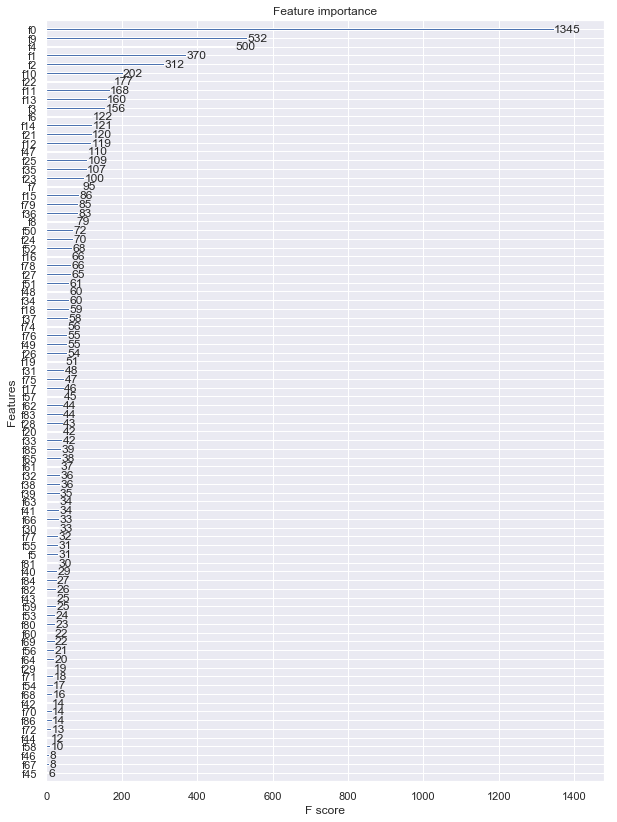

In [34]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(selector_model, (10,14))

## Train

In [35]:
from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=12,
    n_estimators=200,
    min_child_weight=1.1, 
    colsample_bytree=0.7, 
    subsample=0.7, 
#     gamma=0.2,
    reg_lambda=10,
    eta=0.3,    
    seed=2019)

model.fit(
    train_dataset_x, 
    train_dataset_y, 
    eval_metric="rmse", 
    eval_set=[(train_dataset_x, train_dataset_y), (valid_dataset_x, valid_dataset_y)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:3.43001	validation_1-rmse:2.59834
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.30477	validation_1-rmse:2.50081
[2]	validation_0-rmse:3.19661	validation_1-rmse:2.45583
[3]	validation_0-rmse:3.07761	validation_1-rmse:2.36343
[4]	validation_0-rmse:2.97824	validation_1-rmse:2.32629
[5]	validation_0-rmse:2.881	validation_1-rmse:2.24786
[6]	validation_0-rmse:2.79372	validation_1-rmse:2.20479
[7]	validation_0-rmse:2.71904	validation_1-rmse:2.20368
[8]	validation_0-rmse:2.65644	validation_1-rmse:2.19611
[9]	validation_0-rmse:2.59663	validation_1-rmse:2.20029
[10]	validation_0-rmse:2.53322	validation_1-rmse:2.16559
[11]	validation_0-rmse:2.47769	validation_1-rmse:2.12929
[12]	validation_0-rmse:2.43572	validation_1-rmse:2.10964
[13]	validation_0-rmse:2.38097	validation_1-rmse:2.09232
[14]	validation_0-rmse:2.33276	validation_1-rmse:2.0865

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=12, min_child_weight=1.1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.7)

## Save to CSV

In [ ]:
# dataset.to_csv('../features/' + FILENAME + '.csv')

# Reference

## Normal ML Analysis

+ [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

## Time Series

对于revenge的预测很有帮助，但是对于单个店的单个商品而言没有实际的意义，这种预测方式的学习非常有益处

+ [AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)
+ [python时间序列分析](http://www.cnblogs.com/foley/p/5582358.html)
+ [AR、MA及ARMA模型](https://zhuanlan.zhihu.com/p/22248464)
+ [Time Series with Python (ODSC) STA.ipynb](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)
+ [Getting Started with Time Series](https://pyflux.readthedocs.io/en/latest/getting_started.html)
+ [Welcome to Statsmodels’s Documentation](http://www.statsmodels.org/devel/index.html)